In [1]:
import torch
import time
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlrg.hmc import HMCSampler
from rgflow import RGLayer, RGPartition
from itertools import chain

In [2]:
class GaussianModel(torch.nn.Module):
    ''' phi4 model energy
        E = (1/2) sum_<ij> |x_i-x_j|^2 + (r/2) sum_i |x_i|^2

        Parameters:
            r :: real - (initial) value of
            '''
    def __init__(self, r=0.):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))

    def extra_repr(self):
        return f'r={self.r.item()}'

    def return_param(self):
        return torch.exp(self.r)

    def clone(self):
        mdl = type(self)()
        mdl.load_state_dict(self.state_dict())
        return mdl

    def forward(self, x):
        energy = 0.
        for axis in range(1, x.dim()):
            dx2 = (x.roll(1,axis) - x).square().sum(1)
            energy = energy + dx2 / 2
        x2 = x.square().sum(1)
        energy = energy + torch.exp(self.r) * x2 / 2
        energy = energy.view(energy.shape[:1]+(-1,)).sum(-1)
        return energy

In [15]:
def circulant(tensor, dim):
    """get a circulant version of the tensor along the {dim} dimension.

    The additional axis is appended as the last dimension.
    E.g. tensor=[0,1,2], dim=0 --> [[0,1,2],[2,0,1],[1,2,0]]"""
    S = tensor.shape[dim]
    tmp = torch.cat([tensor.flip((dim,)), torch.narrow(tensor.flip((dim,)), dim=dim, start=0, length=S-1)], dim=dim)
    return tmp.unfold(dim, S, 1).flip((-1,))


def permutation_matrix(n):
    # row and column indices - first even, then odd numbers in the latter
    I, J = range(n), list(chain(range(0, n, 2), range(1, n, 2)))
    # the following also works, if you are so inclined.
    # J = [m*2 + d for d, m in map(lambda k: divmod(k, n//2 + n % 2), range(n))]
    res = scipy.sparse.coo_matrix(([1]*n, (I, J))).A
    p = torch.from_numpy(res).type(torch.float32)
    return p


def dft_matrix(n):
    u = 1 / np.sqrt(n) * scipy.linalg.dft(n)
    u = u.astype('complex64')
    u = torch.from_numpy(u)
    return u


def create_diagonal(n, u, c):
    vec = np.sqrt(n) * torch.matmul(u, c)
    vec.pow_(-1)
    D = torch.diag(vec)
    return D


def create_hamiltonian(param, n):
    if n == 1:
        mat = param
    elif n == 2:
        k = (2 + param) * torch.ones(n)
        mat = torch.diag(k) + torch.diag(torch.tensor([-2]), 1) + torch.diag(torch.tensor([-2]), -1)
    elif n > 2:
        k = (2 + param) * torch.ones(n)
        mat = torch.diag(k) + torch.diag(torch.tensor([-1]).repeat(n-1), 1) + torch.diag(torch.tensor([-1]).repeat(n-1), -1)
        mat[0, n-1] = -1
        mat[n-1, 0] = -1
    return mat


def create_G(param, n):
    if n == 1:
        mat = torch.zeros((2, 2))
        mat[0, 0] = 1 / param
        mat[1, 1] = 1
    elif n >= 2:
        inverse_hamil = torch.inverse(create_hamiltonian(param, n))
        mat = torch.block_diag(inverse_hamil, torch.eye(n))
    return mat


def create_inv_G(param, n):
    if n == 1:
        mat = torch.zeros((2, 2))
        mat[0, 0] = param
        mat[1, 1] = 1
    elif n >= 2:
        hamil = create_hamiltonian(param, n)
        mat = torch.block_diag(hamil, torch.eye(n))
    return mat


def create_vec(c, n, kernel_size):
    if kernel_size == n:
        vec = c
    elif kernel_size < n:
        fill = torch.zeros(n - kernel_size)
        vec = torch.cat((c, fill))
    return vec


class LinearCNNRGLearner(torch.nn.Module):
    def __init__(self, uv_model, ir_model, n, kernel_size, device, base_dist='Normal'):
        super().__init__()
        self.size = n
        self.kernel_size = kernel_size
        self.uv_model = uv_model.requires_grad_(False)
        # self.ir_model = uv_model.clone().requires_grad_(True)
        self.ir_model = ir_model.requires_grad_(True)
        self.ir_sampler = HMCSampler(self.ir_model, [1, int(n/2)])
        self.base_dist = getattr(torch.distributions, base_dist)(0., 1.)
        self.uv_param = self.uv_model.return_param()
        self.c = torch.nn.Parameter(torch.randn(self.kernel_size, requires_grad=True)).to(device)
        self.Transpose_P = torch.transpose(permutation_matrix(n), 0, 1)
        self.inv_K = create_hamiltonian(self.uv_param, n)
        self.K = torch.inverse(self.inv_K)


    def get_mat(self):
        mat = torch.matmul(torch.inverse(circulant(create_vec(self.c, self.size, self.kernel_size), 0)), self.Transpose_P)
        return mat

    def get_ir_model(self):
        return self.ir_model

    def sample(self, samples, device):
        with torch.no_grad():
            return self.rsample(samples, device)

    def rsample(self, samples, device):
        x_ir = self.ir_sampler.sample(device, samples=samples)
        z = self.base_dist.rsample([samples, 1]).to(device)
        return x_ir, z

    def loss(self, samples, device, **kwargs):
        ir_param = self.ir_model.return_param()
        mat = torch.matmul(torch.inverse(circulant(create_vec(self.c, self.size, self.kernel_size), 0)), self.Transpose_P)
        G = create_G(ir_param, int(self.size/2))
        x_ir = self.ir_sampler.sample(device, samples=samples, **kwargs)
        z = self.base_dist.rsample([samples, int(self.size/2)]).to(device)
        X_ir = torch.cat((x_ir, z), dim=1)
        # X_ir.requires_grad_(True)
        x_uv = torch.matmul(X_ir, torch.transpose(mat, 0, 1))
        diff = self.uv_model(x_uv) - 1/2 * torch.log(torch.det(G)) - self.ir_model(x_ir) - torch.log(torch.abs(torch.det(mat))) + 1 / 2 * torch.log(torch.det(self.K))
        Loss = diff    # original Loss
        Loss = Loss.mean()
        return Loss, self.ir_model(x_ir).mean()

    def exact_loss(self, device):
        ir_param = self.ir_model.return_param()
        mat = torch.matmul(torch.inverse(circulant(create_vec(self.c, self.size, self.kernel_size), 0)), self.Transpose_P)
        G = create_G(ir_param, int(self.size/2))
        M = torch.matmul(mat, G)
        M = torch.matmul(self.inv_K, M)
        Loss = 1 / 2 * torch.trace(torch.matmul(torch.transpose(mat, 0, 1), M)) + 1 / 2 * torch.log(torch.det(self.K)) - 1 / 2 * torch.log(torch.det(G)) - torch.log(torch.abs(torch.det(mat)))
        return Loss

In [25]:
device = 'cpu'
n = 10
kernel_size = 10
rgl = LinearCNNRGLearner(GaussianModel(r=1.).to(device), GaussianModel(r=1.).to(device), n, kernel_size, device)
optimizer = torch.optim.Adam(rgl.parameters(), lr=0.05)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
print(sum(p.numel() for p in rgl.parameters() if p.requires_grad))
# print(rgl.get_mat())
# print(rgl.get_ir_model())
# print(list(rgl.parameters()))

11


In [26]:
for _ in range(5000):
        optimizer.zero_grad()
        # loss, *rest = rgl.loss(1000, device)
        loss = rgl.exact_loss(device)
        loss.backward(retain_graph=True)
        optimizer.step()
        # scheduler.step()
        print(f'{loss.item()}')
        # print(f'{loss.item()} '+' '.join(f'{r.item()}' for r in rest))

10.608717918395996
9.670148849487305
9.304563522338867
9.108871459960938
8.964263916015625
8.831415176391602
8.696629524230957
8.555336952209473
8.406408309936523
8.250022888183594
8.086814880371094
7.917560577392578
7.743077278137207
7.564252853393555
7.3821210861206055
7.197957992553711
7.013359069824219
6.8303022384643555
6.65118408203125
6.478808403015137
6.3163251876831055
6.167125701904297
6.034782409667969
5.923260688781738
5.837731838226318
5.785780429840088
5.7763872146606445
5.809037685394287
5.8533196449279785
5.86463737487793
5.830206871032715
5.769967079162598
5.7105560302734375
5.669375419616699
5.65179967880249
5.653934001922607
5.666924953460693
5.681325912475586
5.690313339233398
5.69094181060791
5.683586120605469
5.670520782470703
5.654555797576904
5.6381611824035645
5.623104095458984
5.610438823699951
5.600632667541504
5.593730926513672
5.589473724365234
5.58738899230957
5.586853981018066
5.587162971496582
5.587610244750977
5.58758544921875
5.586660385131836
5.584667

In [27]:
print(2 + rgl.get_ir_model().return_param())

tensor(2.3317, grad_fn=<AddBackward0>)


In [28]:
mat = rgl.get_mat()
inv_k = create_hamiltonian(torch.exp(torch.tensor(1.)), n)
M = torch.matmul(inv_k, mat)
M = torch.matmul(torch.transpose(mat, 0, 1), M).detach().numpy()
ir_param = rgl.get_ir_model().return_param().detach().numpy()
inv_G = create_inv_G(ir_param, int(n/2))

Text(0.5, 1.0, '$G^{-1}$')

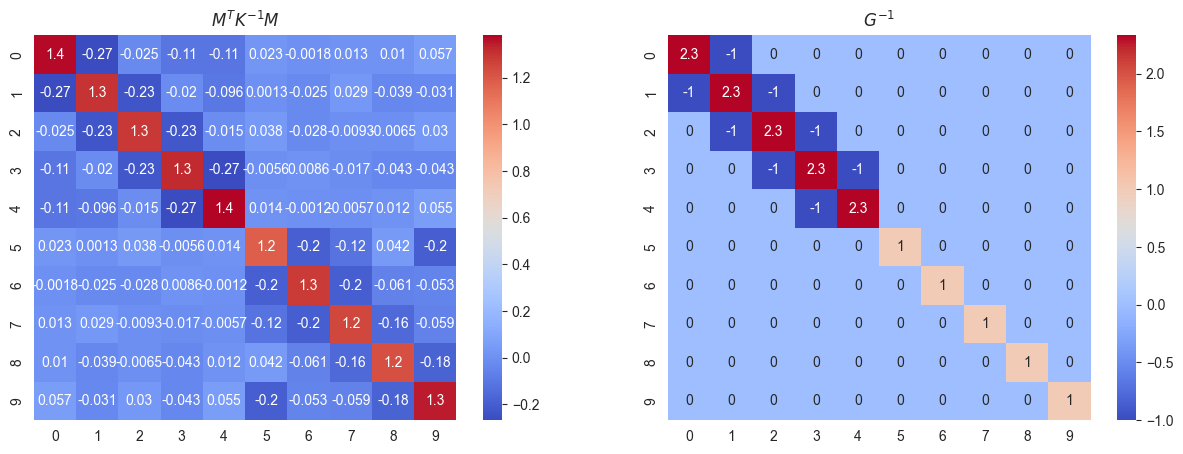

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(M, ax=axes[0], cmap='coolwarm',annot=True)
axes[0].set_title('$M^T K^{-1} M$')
sns.heatmap(inv_G, ax=axes[1], cmap='coolwarm',annot=True)
axes[1].set_title('$G^{-1}$')